### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Scripts/Fake Folder Copy/Python Libraries')

from jb_libraries import *
%matplotlib inline

from dhl_data import *

### Script Settings

In [2]:
pdf_write = 'yes'

In [3]:
# get the current date
now = dt.datetime.now()
now_pretty = str(dt.datetime.now().date())

# the weeks in this report begin on sunday and end on saturday (this is how UPS defines their week)
# here, get the current date, if it's not a saturday, back up to the most recent saturday
d = dt.datetime.now()
i = 0
while d.strftime('%A').lower() != 'saturday':
    d = (now - pd.DateOffset(days = i))
    i += 1
else:
    date_end = d
    
one_year_ago = str((d - pd.DateOffset(years = 1)).date())
one_week_ago = str((d - pd.DateOffset(weeks = 1)).date())

week_end = one_week_ago

image_path = '/Users/jarad/Scripts/Fake Folder Copy/Shipping/Recurring/Weekly UPS Rolling Avg Audit/Images/'

html_path = '/Users/jarad/Scripts/Fake Folder Copy/Shipping/Recurring/Weekly UPS Rolling Avg Audit/HTML/'
html_title = 'Weekly UPS Rolling Avg Audit.html'

pdf_path = '/Users/jarad/Scripts/Fake Folder Copy/Shipping/Recurring/Weekly UPS Rolling Avg Audit/Docs/Weekly Reports/'

style_sheet_path = '/Users/jarad/Scripts/Fake Folder Copy/CSS Stylesheets/Recurring Reports Stylesheet.css'

report_dict = {}

In [4]:
print('report is for week ending {}'.format(week_end))

report is for week ending 2019-06-01


### Get UPS data

In [5]:
ups_super_main = pd.read_sql(
'''
SELECT
orders_id AS 'orders id',
tracking,
DATE(transaction_date) AS date,
IF(account_number = '000071EY05', '71', 'A8') AS account,
charge_description AS 'charge description',
basis_value AS 'gross charge',
netAmount AS 'net charge'
FROM ups_billing
# 6/25/2018 is the beginning of the new rate structure (see email "UPS: Updated Pricing Agreement"), so our rolling avg starts over here
# but make it 6/23, the saturday before 6/25, for simplicity
WHERE DATE(transaction_date) >= '2018-06-23'

''', db)

ups_super_main['date'] = pd.to_datetime(ups_super_main['date'], errors = 'coerce')

### Get Orders data

In [6]:
oid = ups_super_main[ups_super_main['orders id'].map(str).str.len() == 7]['orders id'].min()

orders_main = pd.read_sql(
'''
SELECT
orders_id,
DATE(date_purchased) AS date_purchased,
LOWER(delivery_country) AS delivery_country
FROM orders
WHERE shipping_module_code = 'upsxml'
AND orders_status NOT IN (8,9,14,15) # exclude only fraud and voids, since we pay shipping for returns, replacements, etc.
AND orders_id >= ' '''+ str(oid) +''' '
''', db)

col_fix(orders_main)
orders_main['date purchased'] = pd.to_datetime(orders_main['date purchased'])

orders_main['delivery country'] = orders_main['delivery country'].str.strip()
orders_main['region'] = np.where(orders_main['delivery country'] == 'united states', 'domestic','international')

if orders_main[orders_main['orders id'] == 0].empty:
    pass
else:
    raise ValueError('some OIDs are equal to zero')

### Flag regular customers

In [7]:
ups_super_main['regular customer'] = np.where(ups_super_main['orders id'].isin(orders_main['orders id'].tolist()),'yes','no')

### Flag missing UPS billing data

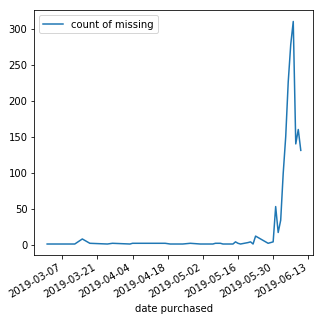

,count of missing
date purchased,
2019-05-02,1
2019-05-06,1
2019-05-07,2
2019-05-08,2
2019-05-09,2
2019-05-10,1
2019-05-13,1
2019-05-14,1
2019-05-15,4


In [8]:
d = pd.to_datetime(week_end) - pd.DateOffset(months = 3)

missing = orders_main[(~orders_main['orders id'].isin(ups_super_main['orders id'].tolist()))
                    & (orders_main['date purchased'] >= d)]

g = missing.groupby('date purchased')[['orders id']].count().rename(columns = {'orders id':'count of missing'})
g.plot(figsize = (5,5))
plt.show()

g.tail(30)

### View delivery region proportions

In [9]:
print('from %s to %s' % (orders_main['date purchased'].min().date(), orders_main['date purchased'].max().date()))

vc = orders_main['region'].value_counts()
vc2 = pd.DataFrame(vc/vc.sum())
vc2.columns = ['delivery region proportions']
vc2.format_(['p2'])

from 2017-10-18 to 2019-06-10


,Delivery Region Proportions
domestic,96.47%
international,3.53%


### Map regions

In [10]:
# nulls are ok since this "region" column is only for regular customers and any nulls will come from non-regular customers
ups_super_main['region'] = ups_super_main['orders id'].map(dict(zip(orders_main['orders id'], orders_main['region'])))

### Create week ending

In [11]:
d1 = ups_super_main['date'].min()
d2 = ups_super_main['date'].max()
dr = pd.date_range(d1,d2)

df = pd.DataFrame(index = dr)
df.index.names = ['date']

df['day name'] = df.index.day_name()
df['day name'] = np.where(df['day name'] != 'Saturday', np.nan, 'Saturday')
df['week ending'] = np.where(df['day name'] == 'Saturday', df.index.map(str).str[:10], np.nan)
df['week ending'].fillna(method = 'bfill', inplace = True)
df.drop('day name',1,inplace = True)

ups_super_main['week ending'] = ups_super_main['date'].map(dict(zip(df.index.to_series(), df['week ending'])))

### Get gross charge per week ending

In [12]:
by_week = ups_super_main.groupby('week ending').agg({'gross charge':'sum',
                                                     'net charge':'sum'})

### Get current rolling average

In [13]:
# 6/25/2018 is the beginning of the new rate structure (see email "UPS: Updated Pricing Agreement"), so our rolling avg starts over here
# but make it 6/23, the saturday before 6/25, for simplicity

contract = '2018-06-30'
rate_change = '2018-12-29'

ix = by_week.index.get_loc(contract)
a = by_week.iloc[:ix].copy()
b = by_week.iloc[ix:].copy()

for df in [a,b]:
    if len(df) > 52: # if there are 52 or more weeks, take the moving average
        df['rolling avg'] = df['gross charge'].rolling(window = 52).mean()
    else:
        df['rolling avg'] = df['gross charge'].expanding().mean()

    
ups_by_week = pd.concat([a,b], sort = False)

# from email with subject line "Quick question on ramp up during w/e 5/27/2018"
# john from UPS says rolling avg w/e 6/02/2018 was $81,552
# db says 88,371
# so MAPE is 8.36%
# a MAPE of <= 10% is expected
mape = 0.0836
ups_by_week['+/-'] = ups_by_week['rolling avg'] * mape

### Get avg cost per package
* For regular customers only (i.e. for orders in orders table)
* Segmented by region

In [14]:
regions = ['domestic','international']
for col in regions:
    ls = []
    df = ups_super_main[(ups_super_main['regular customer'] == 'yes') & (ups_super_main['region'] == col)]
    df2 = df.groupby('week ending').agg({'orders id':'nunique',
                                         'net charge':'sum'})
    df2['avg ' + col + ' charge'] = df2['net charge']/df2['orders id']
    
    ups_by_week = ups_by_week.join(df2[['avg ' + col + ' charge']])
    
ups_by_week.drop(ups_by_week[ups_by_week.index > week_end].index, inplace = True)    

### Most recent three weeks

In [15]:
rec = ups_by_week.tail(3).copy()

ls1 = [0,36230,49815,63400,76985,113225,135870]
ls2 = [36229.99,49814.99,63399.99,76984.99,113224.99,135869.99,np.inf]
ls3 = [1,2,3,4,5,6,7]

ls = []
for index, row in rec.iterrows():
    row_ls = []
    val1 = row['rolling avg'] - row['+/-']
    val2 = row['rolling avg'] + row['+/-']
    for i in range(len(ls1)):
        l = ls1[i]
        u = ls2[i]
        tier = ls3[i]
        if np.logical_and(val1 >= l, val1 < u):
            row_ls.append(tier)
        if np.logical_and(val2 >= l, val2 < u):
            row_ls.append(tier)
    if row_ls[0] == row_ls[1]:
        ls.append(str(row_ls[0]) + 'th')
    else:
        wrt = row_ls[0].map(str) + 'th or ' + row_ls[0].map(str) + 'th'
        ls.append(wrt)
        
rec['tier'] = ls
rec = rec.iloc[::-1]

cols = ['rolling avg',
        '+/-',
        'tier',
        'avg domestic charge',
        'avg international charge']

rec = rec[cols]
rec.reset_index(inplace = True)

fmt = [0,'m0','m0',0,'m2','m2']
display(rec.format_(fmt))
report_dict['current state table'] = rec.format_(fmt).to_html(index = False)

,Week Ending,Rolling Avg,+/-,Tier,Avg Domestic Charge,Avg International Charge
0,2019-06-01,"$90,483","$7,564",5th,$13.10,$45.83
1,2019-05-25,"$90,982","$7,606",5th,$12.85,$41.02
2,2019-05-18,"$90,876","$7,597",5th,$12.93,$39.07


### Written summary

In [16]:
for col in regions:
    cur_val = rec.iloc[0]['avg ' + col + ' charge']
    prev_val = rec.iloc[1]['avg ' + col + ' charge']
    change = cur_val/prev_val - 1
    
    if cur_val > prev_val:
        w = 'higher'
    else:
        w = 'lower'
    
    wrt = '{}: ${:,.2f}, {:,.1f}% {} than the previous week\'s ${:,.2f}'.format(col.title(),
                                                                               cur_val,
                                                                               np.abs(change * 100),
                                                                               w,
                                                                               prev_val)
    report_dict[col + ' avg charge per package'] = wrt
    print(wrt)

Domestic: $13.10, 2.0% higher than the previous week's $12.85
International: $45.83, 11.7% higher than the previous week's $41.02


### Plot it

In [17]:
ups_yellow = '#FCB900'
ups_brown = '#301504'

# ramp up dates, start and end
ls1 = ['2017-07-08',
       '2017-09-24',
       '2017-10-22',
       '2017-11-25',
       '2018-01-13',
       '2018-03-31',
       '2018-05-05']

ls2 = ['2017-09-02',
       '2017-10-22',
       '2017-12-09',
       '2018-03-03',
       '2018-04-21',
       '2018-05-26'] # final ramp up end date as of 6/11/2018

# remove where prior to one_year_ago
remove = []
for x in ls1:
    if pd.to_datetime(x).date() < pd.to_datetime(one_year_ago).date():
        remove.append(x)
        
for x in remove:
    ls1.remove(x)
    
ls2 = ls2[-len(ls1):]    

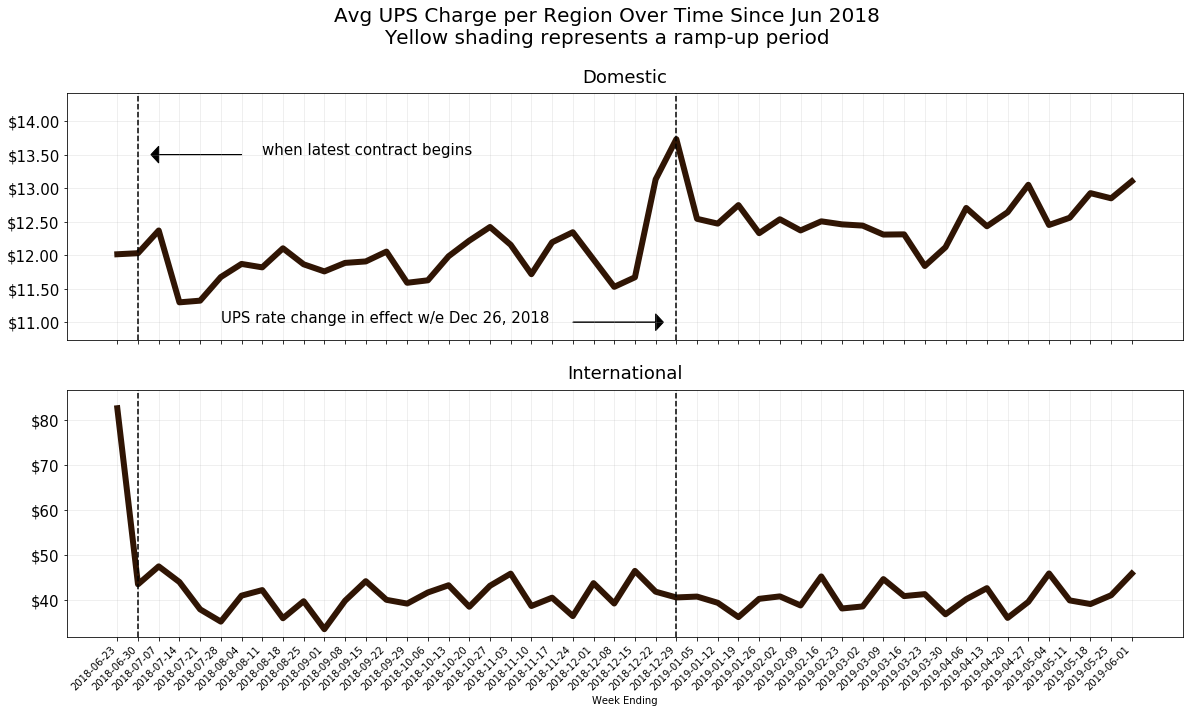

In [18]:
cols = ['avg domestic charge','avg international charge']
chart = ups_by_week[ups_by_week.index >= one_year_ago]

fig, axes = plt.subplots(figsize = (20,10), nrows = 2, ncols = 1)
x = range(len(chart))
y1 = chart[cols[0]]
y2 = chart[cols[1]]

n = len(chart.index)
r = np.arange(0,n,1)
xticks = chart.index[r]

axes[0].plot(x, y1, lw = 6, color = ups_brown)
axes[1].plot(x, y2, lw = 6, color = ups_brown)

for i in range(len(cols)):
    
    min_ = chart[cols[i]].min()
    min_ = min_ - min_/20
    
    max_ = chart[cols[i]].max()
    max_ = max_ + max_/20
    
    axes[i].grid(alpha = 0.25)
    axes[i].set_title(cols[i].split(' ')[1].title(), fontsize = 18, y = 1.02)
    
    axes[i].set_ylim(min_, max_)
    
    if i == 0:
        fmt = '${:,.2f}'
    else:
        fmt = '${:,.0f}'
    
    axes[i].set_yticklabels([fmt.format(x) for x in axes[i].get_yticks()], fontsize = 15)
    axes[i].set_xticks(r)
    
    for j in range(len(ls1)):
        a = chart.index.get_loc(ls1[j])
        b = chart.index.get_loc(ls2[j])
        axes[i].axvline(a, color = 'black')
        axes[i].axvline(b, color = 'black')
        axes[i].fill_between([a,b],max_,color = ups_yellow, zorder = 2)
        
    c1 = chart.index.get_loc(contract)
    axes[i].axvline(c1, color = 'black', ls = '--')
    
    c2 = chart.index.get_loc(rate_change)
    axes[i].axvline(c2, color = 'black', ls = '--')    
    
axes[0].set_xticklabels('')
axes[1].set_xticklabels(xticks, rotation = 45, ha = 'right')
axes[1].set_xlabel('Week Ending')

arrow = 5    
axes[0].arrow(x = c1 + 5, y = 13.50, dx = -4, dy = 0, head_width = 0.25, color = 'black')
axes[0].annotate('when latest contract begins', xy = (c1 + arrow + 1, 13.50), fontsize = 15)

arrow = 5    
axes[0].arrow(x = c2 - 5, y = 11.00, dx = 4, dy = 0, head_width = 0.25, color = 'black')
axes[0].annotate('UPS rate change in effect w/e Dec 26, 2018', xy = (c2 - 22, 11.00), fontsize = 15)


title = 'Avg UPS Charge per Region Over Time'
d = jb_dates(pd.Series(chart.index.min()), 'year and month pretty')[0]
plt.suptitle(title + ' Since {}\nYellow shading represents a ramp-up period'.format(d), fontsize = 20, y = 1)
plt.savefig(image_path + title, bbox_inches = 'tight')
plt.show()

### Confidence intervals for avg charge per international shipment

In [19]:
d = str((pd.to_datetime(week_end) - pd.DateOffset(months = 3)).date())
conf_dfs = {}

# DHL
df1 = dhl_main[(dhl_main['date'] >= d) & (dhl_main['incoming/outgoing'] == 'outgoing')]
df2 = df1.groupby('orders id')[['shipping charge']].sum()
conf_dfs['dhl'] = jb_conf(df2)

# UPS
oids = orders_main[orders_main['date purchased'] >= d]['orders id'].tolist()
df1 = ups_super_main[(ups_super_main['orders id'].isin(oids))
                    & (ups_super_main['regular customer'] == 'yes')
                    & (ups_super_main['region'] == 'international')]
df2 = df1.groupby('orders id')[['net charge']].sum()
conf_dfs['ups'] = jb_conf(df2)

In [20]:
conf = pd.DataFrame(index = ['lower','mean','upper','stand dev','sample size'])
for k,v in conf_dfs.items():
    df = conf_dfs[k]
    df.columns = [k]
    conf = conf.join(df)
    
conf.columns = [x.upper() for x in conf.columns]

fmt = ['m2','m2']
conf.loc[:'upper'].format_(fmt)

,DHL,UPS
lower,$37.39,$39.45
mean,$38.30,$40.84
upper,$39.21,$42.23


### Avg per package comparison

In [21]:
compare = 'Considering only international shipments over the most recent three months, the average charge for a \
DHL package is between ${:,.2f} and ${:,.2f} while for UPS it is between ${:,.2f} and ${:,.2f}'.format(conf_dfs['dhl'].loc['lower'][0],
                                                                                                       conf_dfs['dhl'].loc['upper'][0],
                                                                                                       conf_dfs['ups'].loc['lower'][0],
                                                                                                       conf_dfs['ups'].loc['upper'][0])
print(compare)
report_dict['compare'] = compare

Considering only international shipments over the most recent three months, the average charge for a DHL package is between $37.39 and $39.21 while for UPS it is between $39.45 and $42.23


### Build HTML output for automatic report

In [22]:
print('report covers until week ending {}'.format(week_end))

report covers until week ending 2019-06-01


In [23]:
if pdf_write == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'week_end':week_end,
                    'now':now_pretty,
                    'domestic_avg_charge_per_package':report_dict['domestic avg charge per package'],
                    'international_avg_charge_per_package':report_dict['international avg charge per package'],
                    'current_state_table':report_dict['current state table'],
                    'compare':report_dict['compare']}

    html_out = template.render(template_vars)

    from weasyprint import HTML
    report_title = 'w.e. ' + week_end + ' - Weekly UPS Rolling Avg Audit.pdf'
    HTML(string = html_out).write_pdf(pdf_path + report_title,
                                      stylesheets = [style_sheet_path])                               

In [24]:
print('done')

done


In [29]:

python.__version__

NameError: name 'python' is not defined